# Gender Classification with GoogleNet

##### Mount Google Drive

In [ ]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


##### Import All Library

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.mixed_precision.loss_scale_optimizer import optimizer
from keras import regularizers
from keras.preprocessing import image
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint
from keras.utils import load_img, img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

#### Devine CelebA Datasets

In [ ]:
bsc_path = '/content/mount/MyDrive/Datasets/celebA'
img_path = os.path.join(bsc_path, 'images')
feature_path = os.path.join(bsc_path, 'gender_classification.csv')

In [ ]:
number_images = len(os.listdir(img_path))
print('Total Images', number_images)

Total Images 10000


In [ ]:
# Read the attributes csv files in a dataframe format.
df = pd.read_csv(feature_path)
df.columns = ["image_id", "Gender"]
df.head()

,image_id,Gender
0,000041.jpg,1
1,000044.jpg,0
2,000047.jpg,0
3,000050.jpg,1
4,000063.jpg,0


# Exploratory Data Analysis

Melihat beberapa image yang ada pada dataset yang akan digunakan untuk membuat model

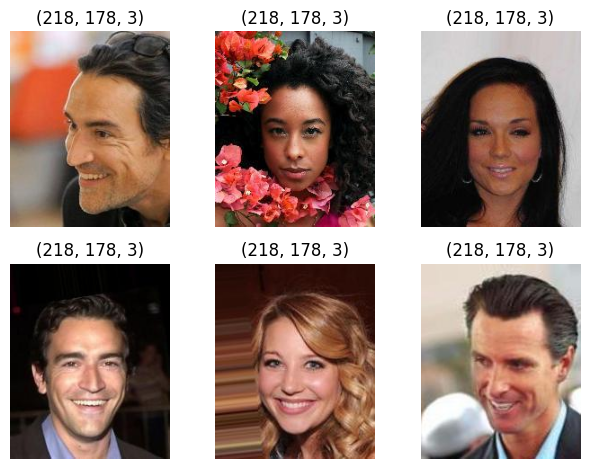

In [ ]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    
    # Read an Image.
    img = cv2.imread(img_path + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

#### Category Distribution

Melihat distribusi dari category gender

In [ ]:
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

0    5861
1    4139
Name: Gender, dtype: int64


0 = Female (Perempuan), 1 = Male (Laki-laki)

#Data Preprocessing

#### Drop Imbalance

In [ ]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")

<Axes: >

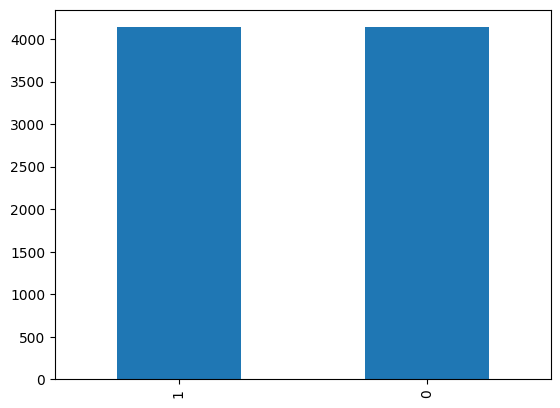

In [ ]:
df["Gender"].value_counts().plot.bar()

Berhasil menyeimbangkan data label 0 menyesuaikan dengan label 1 berjumlah 4139 setiap label nya

#### Change Label Value To String

In [ ]:
df["Gender"] = df["Gender"].map({0: "0", 1: "1"})
df.head()

,image_id,Gender
0,000041.jpg,1
1,000044.jpg,0
2,000047.jpg,0
3,000050.jpg,1
4,000063.jpg,0


# Train Test Split Data

1. Data akan dibagi menjadi beberapa ukuran training dan test size = 80:20, 70:30, 60:40
2. Diubah ukuran image nya menjadi 224 x 224

In [ ]:
train_df_82, test_df_82 = train_test_split(df, test_size=0.2)
train_df_73, test_df_73 = train_test_split(df, test_size=0.3)
train_df_64, test_df_64 = train_test_split(df, test_size=0.4)

In [ ]:
print("Total Train Sample Images 80:20 : ", len(train_df_82))
print("Total Test Sample Images 80:20 : ", len(test_df_82))
print("==========================================")
print("Total Train Sample Images 70:30 : ", len(train_df_73))
print("Total Test Sample Images 70:30 : ", len(test_df_73))
print("==========================================")
print("Total Train Sample Images 60:40 : ", len(train_df_64))
print("Total Test Sample Images 60:40 : ", len(test_df_64))

Total Train Sample Images 80:20 :  6622
Total Test Sample Images 80:20 :  1656
Total Train Sample Images 70:30 :  5794
Total Test Sample Images 70:30 :  2484
Total Train Sample Images 60:40 :  4966
Total Test Sample Images 60:40 :  3312


#### Create Image Data Generator for Train and Test Data

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range= 15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1
)
test_gen = ImageDataGenerator(rescale=1./255)

#### Split Data 80:20

In [ ]:
#train_generator 80:20
train_generator_82 = train_datagen.flow_from_dataframe(
    train_df_82, 
    img_path, 
    x_col='image_id',
    y_col='Gender',
    target_size=(224,224),
    class_mode='binary'
    )
test_generator_82 = test_gen.flow_from_dataframe(
    test_df_82, 
    img_path,  
    x_col='image_id',
    y_col='Gender',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 6622 validated image filenames belonging to 2 classes.
Found 1656 validated image filenames belonging to 2 classes.


#### Split Data 70:30

In [ ]:
#train_generator 70:30
train_generator_73 = train_datagen.flow_from_dataframe(
    train_df_73, 
    img_path, 
    x_col='image_id',
    y_col='Gender',
    target_size=(224,224),
    class_mode='binary'
    )
test_generator_73 = test_gen.flow_from_dataframe(
    test_df_73, 
    img_path,  
    x_col='image_id',
    y_col='Gender',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 5794 validated image filenames belonging to 2 classes.
Found 2484 validated image filenames belonging to 2 classes.


#### Split Data 60:40

In [ ]:
#train_generator 60:40
train_generator_64 = train_datagen.flow_from_dataframe(
    train_df_64, 
    img_path, 
    x_col='image_id',
    y_col='Gender',
    target_size=(224,224),
    class_mode='binary'
    )
test_generator_64 = test_gen.flow_from_dataframe(
    test_df_64, 
    img_path,  
    x_col='image_id',
    y_col='Gender',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 4966 validated image filenames belonging to 2 classes.
Found 3312 validated image filenames belonging to 2 classes.


#Modelling

#### Create Model

In [ ]:
# definisikan model GoogleNet / Inception v1
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model


# Create Model untuk data split 80:20 




## Learning Rate 0.001

In [ ]:
# create model
model_82_0001 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_82_0001.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82_0001.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82_0001 = model_82_0001.fit(train_generator_82, epochs=5, verbose = 1, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 0.6445 - accuracy: 0.6309
Epoch 1: val_accuracy improved from -inf to 0.74879, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_0001.h5
207/207 [==============================] - 528s 3s/step - loss: 0.6445 - accuracy: 0.6309 - val_loss: 0.5120 - val_accuracy: 0.7488
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.5340 - accuracy: 0.7366
Epoch 2: val_accuracy improved from 0.74879 to 0.78986, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_0001.h5
207/207 [==============================] - 102s 492ms/step - loss: 0.5340 - accuracy: 0.7366 - val_loss: 0.4522 - val_accuracy: 0.7899
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.4667 - accuracy: 0.7810
Epoch 3: val_accuracy improved from 0.78986 to 0.83152, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

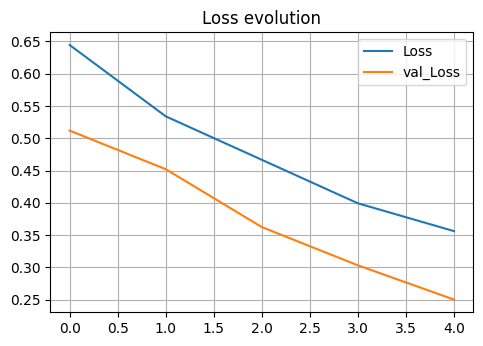

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82_0001.history['loss'], label='Loss')
plt.plot(history_82_0001.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

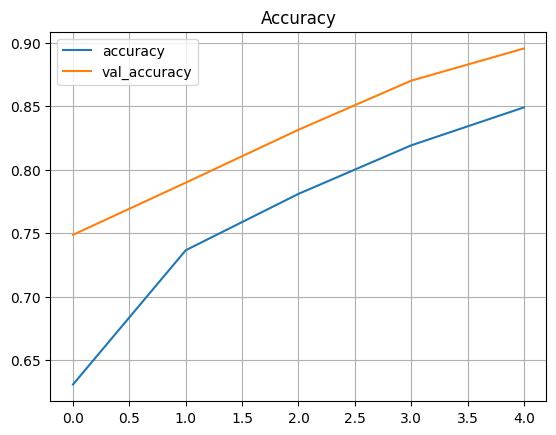

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82_0001.history['accuracy'],label='accuracy')
plt.plot(history_82_0001.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82_0001, test_acc_82_0001 = model_82_0001.evaluate(test_generator_82)
print('Test loss:', test_loss_82_0001)
print('Test accuracy:', test_acc_82_0001)

52/52 [==============================] - 5s 93ms/step - loss: 0.2503 - accuracy: 0.8955
Test loss: 0.2503390312194824
Test accuracy: 0.895531415939331


In [ ]:
predict_82_0001 = model_82_0001.predict(test_generator_82)

52/52 [==============================] - 6s 111ms/step


In [ ]:
prediction_82_0001 = predict_82_0001.argmax(axis=-1)
test_df_82['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction_82_0001]
test_df_82

,image_id,Gender,Prediction
5302,107395.jpg,0,0
2516,050660.jpg,1,0
4014,081538.jpg,1,0
5093,103278.jpg,1,0
3154,063944.jpg,0,0
...,...,...,...
3183,064564.jpg,0,0
1380,027923.jpg,1,0
7358,149293.jpg,0,0
1291,026059.jpg,0,0


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[  0, 801],
       [  0, 855]])

In [ ]:
true_classes = test_generator_82.classes

class_labels = list(test_generator_82.class_indices.keys())

report_82_0001 = classification_report(true_classes, prediction_82_0001, target_names=class_labels)
print(report_82_0001)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       849
           1       0.00      0.00      0.00       807

    accuracy                           0.51      1656
   macro avg       0.26      0.50      0.34      1656
weighted avg       0.26      0.51      0.35      1656



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


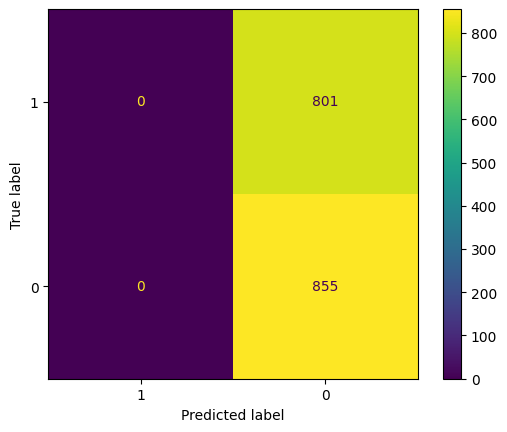

In [ ]:
disp_82_0001 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82_0001.plot()
plt.show()

## Learning Rate 0.01

In [ ]:
# create model
model_82_001 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.01)
model_82_001.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82_001.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82_001 = model_82_001.fit(train_generator_82, epochs=5, verbose = 1, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 15.9521 - accuracy: 0.5071
Epoch 1: val_accuracy improved from -inf to 0.51268, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_001.h5
207/207 [==============================] - 103s 486ms/step - loss: 15.9521 - accuracy: 0.5071 - val_loss: 0.6929 - val_accuracy: 0.5127
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5021
Epoch 2: val_accuracy did not improve from 0.51268
207/207 [==============================] - 102s 493ms/step - loss: 0.6934 - accuracy: 0.5021 - val_loss: 0.6935 - val_accuracy: 0.4873
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.4938
Epoch 3: val_accuracy did not improve from 0.51268
207/207 [==============================] - 104s 504ms/step - loss: 0.6938 - accuracy: 0.4938 - val_loss: 0.6936 - val_accuracy: 0.4873
Epoch 4/5
207/207 [==============================] - E

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

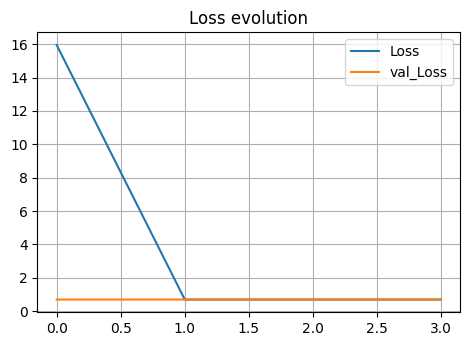

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82_001.history['loss'], label='Loss')
plt.plot(history_82_001.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

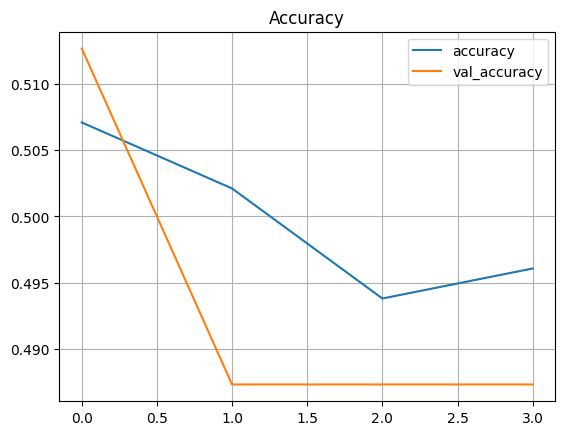

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82_001.history['accuracy'],label='accuracy')
plt.plot(history_82_001.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82_001, test_acc_82_001 = model_82_001.evaluate(test_generator_82)
print('Test loss:', test_loss_82_001)
print('Test accuracy:', test_acc_82_001)

52/52 [==============================] - 5s 95ms/step - loss: 0.6933 - accuracy: 0.4873
Test loss: 0.6933398246765137
Test accuracy: 0.48731884360313416


In [ ]:
predict_82_001 = model_82_001.predict(test_generator_82)

52/52 [==============================] - 5s 99ms/step


In [ ]:
prediction_82_001 = predict_82_001.argmax(axis=-1)
test_df_82['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction_82_001]
test_df_82

,image_id,Gender,Prediction
5302,107395.jpg,0,0
2516,050660.jpg,1,0
4014,081538.jpg,1,0
5093,103278.jpg,1,0
3154,063944.jpg,0,0
...,...,...,...
3183,064564.jpg,0,0
1380,027923.jpg,1,0
7358,149293.jpg,0,0
1291,026059.jpg,0,0


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[  0, 801],
       [  0, 855]])

In [ ]:
true_classes = test_generator_82.classes

class_labels = list(test_generator_82.class_indices.keys())

report_82_001 = classification_report(true_classes, prediction_82_001, target_names=class_labels)
print(report_82_001)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       849
           1       0.00      0.00      0.00       807

    accuracy                           0.51      1656
   macro avg       0.26      0.50      0.34      1656
weighted avg       0.26      0.51      0.35      1656



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


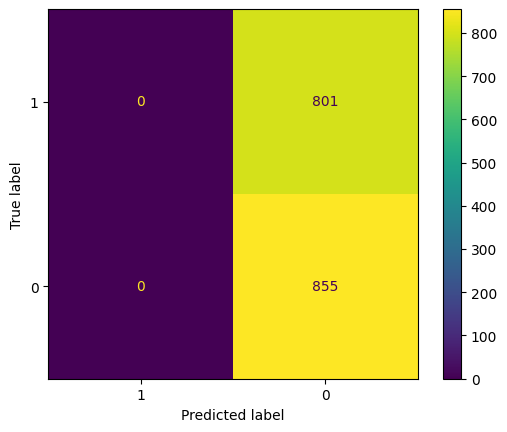

In [ ]:
disp_82_001 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82_001.plot()
plt.show()

## Learning Rate 0.1

In [ ]:
# create model
model_82_01 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.1)
model_82_01.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82_01.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82_01 = model_82_01.fit(train_generator_82, epochs=5, verbose = 1, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 525181.1875 - accuracy: 0.5089
Epoch 1: val_accuracy improved from -inf to 0.48732, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_01.h5
207/207 [==============================] - 115s 550ms/step - loss: 525181.1875 - accuracy: 0.5089 - val_loss: 0.6937 - val_accuracy: 0.4873
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.4949
Epoch 2: val_accuracy did not improve from 0.48732
207/207 [==============================] - 164s 795ms/step - loss: 0.6948 - accuracy: 0.4949 - val_loss: 0.6954 - val_accuracy: 0.4873
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.4946
Epoch 3: val_accuracy did not improve from 0.48732
207/207 [==============================] - 121s 580ms/step - loss: 0.6953 - accuracy: 0.4946 - val_loss: 0.6967 - val_accuracy: 0.4873
Epoch 4/5
207/207 [============================

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

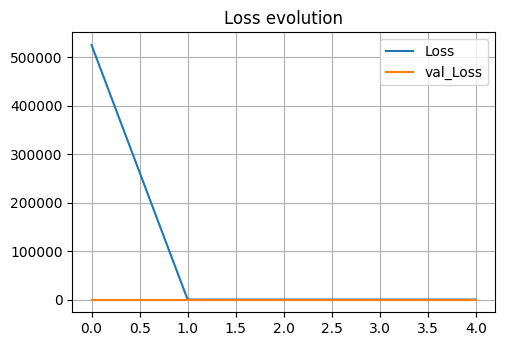

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82_01.history['loss'], label='Loss')
plt.plot(history_82_01.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

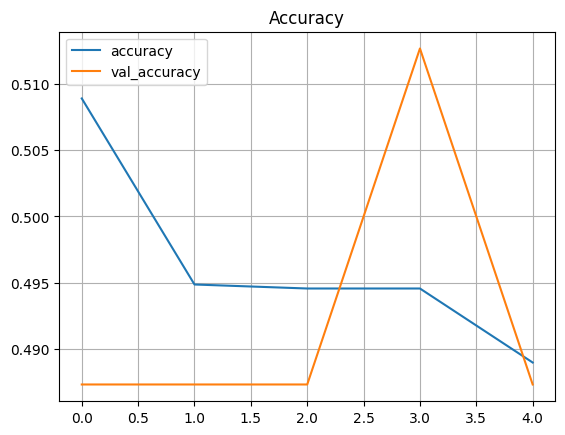

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82_01.history['accuracy'],label='accuracy')
plt.plot(history_82_01.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82_01, test_acc_82_01 = model_82_01.evaluate(test_generator_82)
print('Test loss:', test_loss_82_01)
print('Test accuracy:', test_acc_82_01)

52/52 [==============================] - 5s 104ms/step - loss: 0.6932 - accuracy: 0.4873
Test loss: 0.6931750178337097
Test accuracy: 0.48731884360313416


In [ ]:
predict_82_01 = model_82_01.predict(test_generator_82)

52/52 [==============================] - 6s 111ms/step


In [ ]:
prediction_82_01 = predict_82_01.argmax(axis=-1)
test_df_82['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction_82_01]
test_df_82

,image_id,Gender,Prediction
5302,107395.jpg,0,0
2516,050660.jpg,1,0
4014,081538.jpg,1,0
5093,103278.jpg,1,0
3154,063944.jpg,0,0
...,...,...,...
3183,064564.jpg,0,0
1380,027923.jpg,1,0
7358,149293.jpg,0,0
1291,026059.jpg,0,0


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[  0, 801],
       [  0, 855]])

In [ ]:
true_classes = test_generator_82.classes

class_labels = list(test_generator_82.class_indices.keys())

report_82_01 = classification_report(true_classes, prediction_82_01, target_names=class_labels)
print(report_82_01)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       849
           1       0.00      0.00      0.00       807

    accuracy                           0.51      1656
   macro avg       0.26      0.50      0.34      1656
weighted avg       0.26      0.51      0.35      1656



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


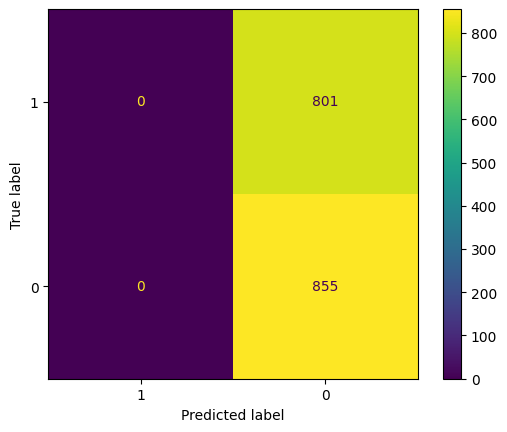

In [ ]:
disp_82_01 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82_01.plot()
plt.show()

#### Kesimpulan Learning Rate
* Penggunaan learning rate nilai 0.001 lebih optimal karena nilai loss nya lebih kecil dibandingkan dengan penggunaan learning rate 0.01, 0.1

## Batch_size 16

In [ ]:
# create model
model_82_bs16 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_82_bs16.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82_bs16.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82_bs16 = model_82_bs16.fit(train_generator_82, epochs=5, verbose = 1, batch_size=16, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.6512
Epoch 1: val_accuracy improved from -inf to 0.75604, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_bs16.h5
207/207 [==============================] - 105s 504ms/step - loss: 0.6223 - accuracy: 0.6512 - val_loss: 0.4995 - val_accuracy: 0.7560
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.5162 - accuracy: 0.7475
Epoch 2: val_accuracy improved from 0.75604 to 0.83394, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_bs16.h5
207/207 [==============================] - 102s 493ms/step - loss: 0.5162 - accuracy: 0.7475 - val_loss: 0.3550 - val_accuracy: 0.8339
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.8519
Epoch 3: val_accuracy improved from 0.83394 to 0.89795, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classificati

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

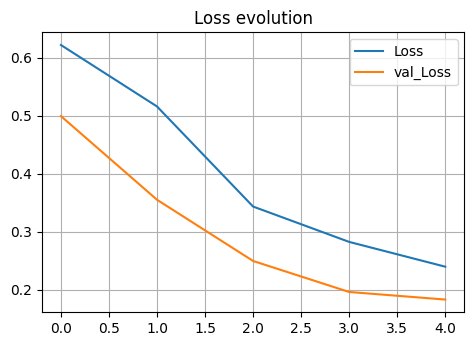

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82_bs16.history['loss'], label='Loss')
plt.plot(history_82_bs16.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

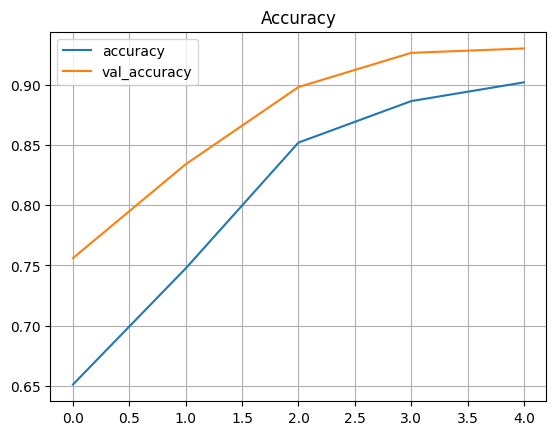

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82_bs16.history['accuracy'],label='accuracy')
plt.plot(history_82_bs16.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82_bs16, test_acc_82_bs16 = model_82_bs16.evaluate(test_generator_82)
print('Test loss:', test_loss_82_bs16)
print('Test accuracy:', test_acc_82_bs16)

52/52 [==============================] - 6s 108ms/step - loss: 0.1827 - accuracy: 0.9300
Test loss: 0.18265418708324432
Test accuracy: 0.9299516677856445


In [ ]:
predict_82_bs16 = model_82_bs16.predict(test_generator_82)

52/52 [==============================] - 5s 96ms/step


In [ ]:
prediction_82_bs16 = predict_82_bs16.argmax(axis=-1)
test_df_82['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction_82_bs16]
test_df_82

,image_id,Gender,Prediction
5302,107395.jpg,0,0
2516,050660.jpg,1,0
4014,081538.jpg,1,0
5093,103278.jpg,1,0
3154,063944.jpg,0,0
...,...,...,...
3183,064564.jpg,0,0
1380,027923.jpg,1,0
7358,149293.jpg,0,0
1291,026059.jpg,0,0


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[  0, 801],
       [  0, 855]])

In [ ]:
true_classes = test_generator_82.classes

class_labels = list(test_generator_82.class_indices.keys())

report_82_bs16 = classification_report(true_classes, prediction_82_bs16, target_names=class_labels)
print(report_82_bs16)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       849
           1       0.00      0.00      0.00       807

    accuracy                           0.51      1656
   macro avg       0.26      0.50      0.34      1656
weighted avg       0.26      0.51      0.35      1656



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


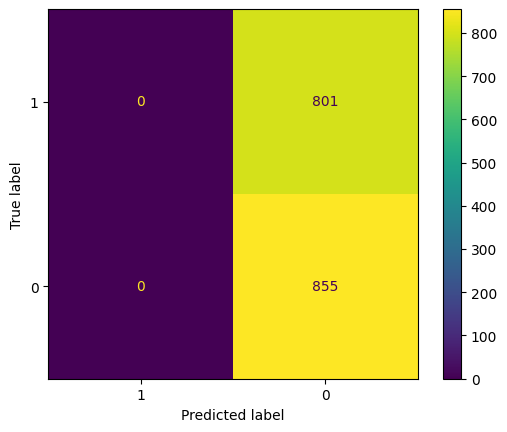

In [ ]:
disp_82_bs16 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82_bs16.plot()
plt.show()

## Batch_size 32

In [ ]:
# create model
model_82_bs32 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_82_bs32.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82_bs32.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82_bs32 = model_82_bs32.fit(train_generator_82, epochs=5, verbose = 1, batch_size=32, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.5026
Epoch 1: val_accuracy improved from -inf to 0.48732, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_bs32.h5
207/207 [==============================] - 101s 486ms/step - loss: 0.7036 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.4873
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5054
Epoch 2: val_accuracy improved from 0.48732 to 0.51268, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_bs32.h5
207/207 [==============================] - 103s 495ms/step - loss: 0.6932 - accuracy: 0.5054 - val_loss: 0.6931 - val_accuracy: 0.5127
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4961
Epoch 3: val_accuracy did not improve from 0.51268
207/207 [==============================] - 97s 469ms/step - loss: 0.6934 - accuracy: 

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

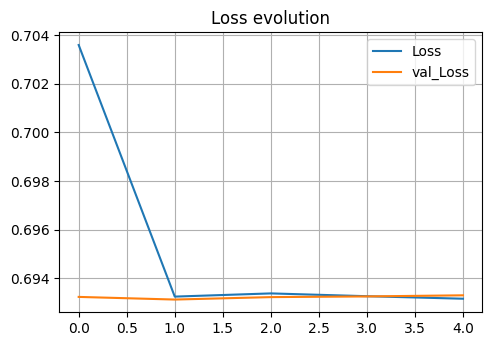

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82_bs32.history['loss'], label='Loss')
plt.plot(history_82_bs32.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

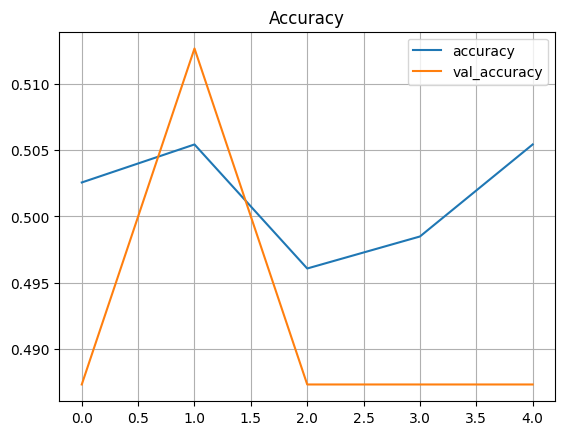

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82_bs32.history['accuracy'],label='accuracy')
plt.plot(history_82_bs32.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82_bs32, test_acc_82_bs32 = model_82_bs32.evaluate(test_generator_82)
print('Test loss:', test_loss_82_bs32)
print('Test accuracy:', test_acc_82_bs32)

52/52 [==============================] - 5s 99ms/step - loss: 0.6933 - accuracy: 0.4873
Test loss: 0.6932961940765381
Test accuracy: 0.48731884360313416


In [ ]:
predict_82_bs32 = model_82_bs32.predict(test_generator_82)

52/52 [==============================] - 6s 107ms/step


In [ ]:
prediction_82_bs32 = predict_82_bs32.argmax(axis=-1)
test_df_82['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction_82_bs32]
test_df_82

,image_id,Gender,Prediction
5302,107395.jpg,0,0
2516,050660.jpg,1,0
4014,081538.jpg,1,0
5093,103278.jpg,1,0
3154,063944.jpg,0,0
...,...,...,...
3183,064564.jpg,0,0
1380,027923.jpg,1,0
7358,149293.jpg,0,0
1291,026059.jpg,0,0


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[  0, 801],
       [  0, 855]])

In [ ]:
true_classes = test_generator_82.classes

class_labels = list(test_generator_82.class_indices.keys())

report_82_bs32 = classification_report(true_classes, prediction_82_bs32, target_names=class_labels)
print(report_82_bs32)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       849
           1       0.00      0.00      0.00       807

    accuracy                           0.51      1656
   macro avg       0.26      0.50      0.34      1656
weighted avg       0.26      0.51      0.35      1656



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


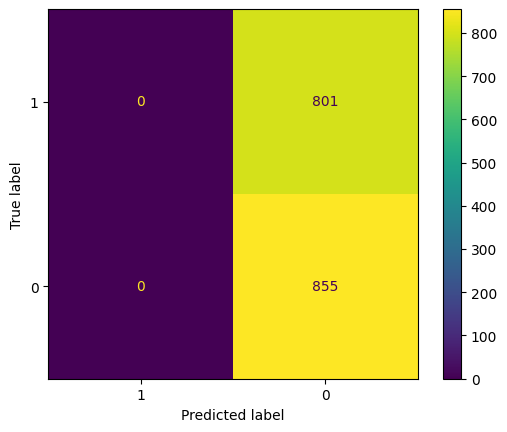

In [ ]:
disp_82_bs32 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82_bs32.plot()
plt.show()

## Batch_size 64

In [ ]:
# create model
model_82_bs64 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_82_bs64.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82_bs64.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82_bs64 = model_82_bs64.fit(train_generator_82, epochs=5, verbose = 1, batch_size=64, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.5217
Epoch 1: val_accuracy improved from -inf to 0.51268, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_bs64.h5
207/207 [==============================] - 98s 470ms/step - loss: 0.6952 - accuracy: 0.5217 - val_loss: 0.6921 - val_accuracy: 0.5127
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.6725 - accuracy: 0.5577
Epoch 2: val_accuracy improved from 0.51268 to 0.73853, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_bs64.h5
207/207 [==============================] - 102s 495ms/step - loss: 0.6725 - accuracy: 0.5577 - val_loss: 0.5385 - val_accuracy: 0.7385
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.5692 - accuracy: 0.7197
Epoch 3: val_accuracy improved from 0.73853 to 0.75181, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classificatio

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

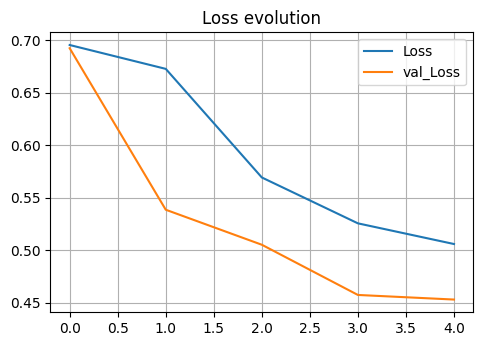

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82_bs64.history['loss'], label='Loss')
plt.plot(history_82_bs64.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

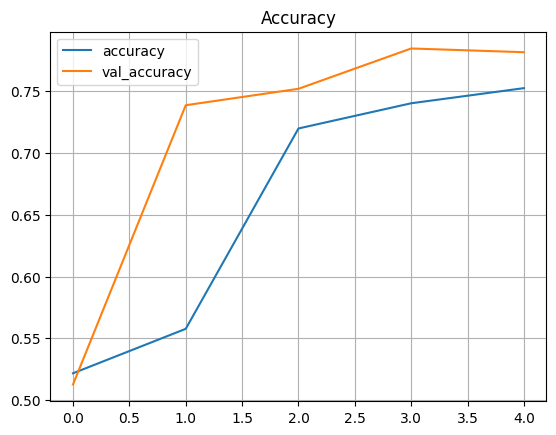

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82_bs64.history['accuracy'],label='accuracy')
plt.plot(history_82_bs64.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82_bs64, test_acc_82_bs64 = model_82_bs64.evaluate(test_generator_82)
print('Test loss:', test_loss_82_bs64)
print('Test accuracy:', test_acc_82_bs64)

52/52 [==============================] - 5s 95ms/step - loss: 0.4531 - accuracy: 0.7814
Test loss: 0.4530864953994751
Test accuracy: 0.7814009785652161


In [ ]:
predict_82_bs64 = model_82_bs64.predict(test_generator_82)

52/52 [==============================] - 6s 107ms/step


In [ ]:
prediction_82_bs64 = predict_82_bs64.argmax(axis=-1)
test_df_82['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction_82_bs64]
test_df_82

,image_id,Gender,Prediction
5302,107395.jpg,0,0
2516,050660.jpg,1,0
4014,081538.jpg,1,0
5093,103278.jpg,1,0
3154,063944.jpg,0,0
...,...,...,...
3183,064564.jpg,0,0
1380,027923.jpg,1,0
7358,149293.jpg,0,0
1291,026059.jpg,0,0


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[  0, 801],
       [  0, 855]])

In [ ]:
true_classes = test_generator_82.classes

class_labels = list(test_generator_82.class_indices.keys())

report_82_bs64 = classification_report(true_classes, prediction_82_bs64, target_names=class_labels)
print(report_82_bs64)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       849
           1       0.00      0.00      0.00       807

    accuracy                           0.51      1656
   macro avg       0.26      0.50      0.34      1656
weighted avg       0.26      0.51      0.35      1656



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


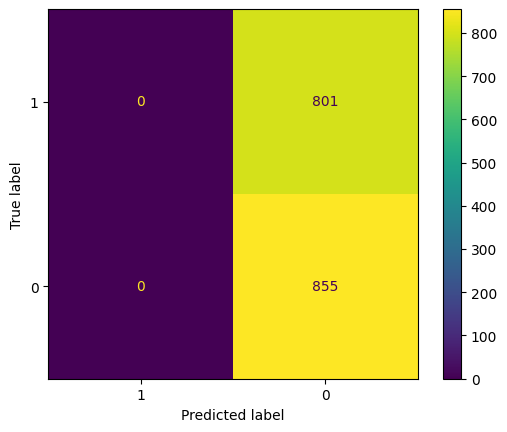

In [ ]:
disp_82_bs64 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82_bs64.plot()
plt.show()

## Split Data 80:20

In [ ]:
# create model
model_82 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_82.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82 = model_82.fit(train_generator_82, epochs=20, verbose = 1, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/20
207/207 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.6062
Epoch 1: val_accuracy improved from -inf to 0.74094, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82.h5
207/207 [==============================] - 99s 476ms/step - loss: 0.6534 - accuracy: 0.6062 - val_loss: 0.5554 - val_accuracy: 0.7409
Epoch 2/20
207/207 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.7082
Epoch 2: val_accuracy improved from 0.74094 to 0.77778, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82.h5
207/207 [==============================] - 101s 486ms/step - loss: 0.5707 - accuracy: 0.7082 - val_loss: 0.4881 - val_accuracy: 0.7778
Epoch 3/20
207/207 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.7490
Epoch 3: val_accuracy improved from 0.77778 to 0.78140, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

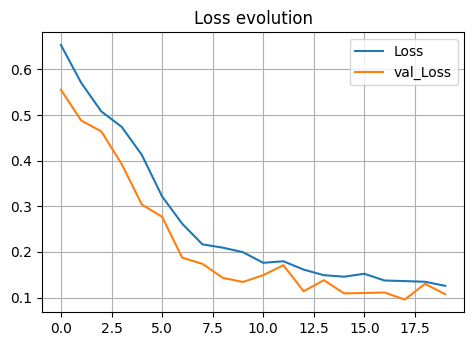

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82.history['loss'], label='Loss')
plt.plot(history_82.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

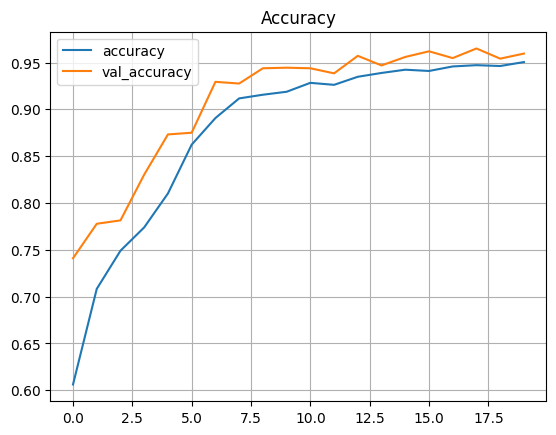

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82.history['accuracy'],label='accuracy')
plt.plot(history_82.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82, test_acc_82 = model_82.evaluate(test_generator_82)
print('Test loss:', test_loss_82)
print('Test accuracy:', test_acc_82)

52/52 [==============================] - 5s 102ms/step - loss: 0.1072 - accuracy: 0.9595
Test loss: 0.1072450652718544
Test accuracy: 0.9595410823822021


In [ ]:
predict_82 = model_82.predict(test_generator_82)

52/52 [==============================] - 5s 94ms/step


In [ ]:
prediction_82 = predict_82.argmax(axis=-1)
test_df_82['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction_82]
test_df_82

,image_id,Gender,Prediction
5302,107395.jpg,0,0
2516,050660.jpg,1,0
4014,081538.jpg,1,0
5093,103278.jpg,1,0
3154,063944.jpg,0,0
...,...,...,...
3183,064564.jpg,0,0
1380,027923.jpg,1,0
7358,149293.jpg,0,0
1291,026059.jpg,0,0


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[  0, 801],
       [  0, 855]])

In [ ]:
true_classes = test_generator_82.classes

class_labels = list(test_generator_82.class_indices.keys())

report_82 = classification_report(true_classes, prediction_82, target_names=class_labels)
print(report_82)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       849
           1       0.00      0.00      0.00       807

    accuracy                           0.51      1656
   macro avg       0.26      0.50      0.34      1656
weighted avg       0.26      0.51      0.35      1656



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


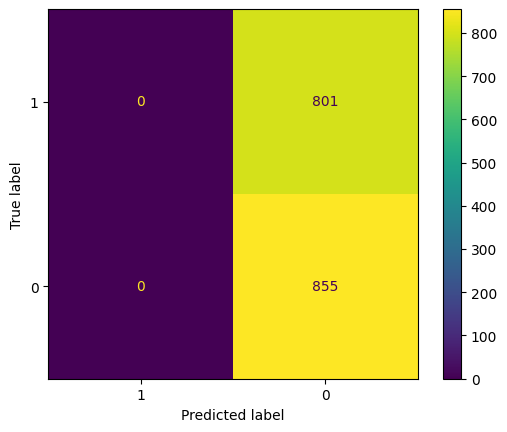

In [ ]:
disp_82 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82.plot()
plt.show()

## Split Data 70:30

In [ ]:
# create model
model_73 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_73.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_73.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_73 = model_73.fit(train_generator_73, epochs=20, verbose = 1, validation_data=test_generator_73, callbacks=[checkpoint, earlystop])

Epoch 1/20
182/182 [==============================] - ETA: 0s - loss: 0.6381 - accuracy: 0.6277
Epoch 1: val_accuracy improved from -inf to 0.71779, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_73.h5
182/182 [==============================] - 91s 493ms/step - loss: 0.6381 - accuracy: 0.6277 - val_loss: 0.5521 - val_accuracy: 0.7178
Epoch 2/20
181/182 [============================>.] - ETA: 0s - loss: 0.5632 - accuracy: 0.7177
Epoch 2: val_accuracy improved from 0.71779 to 0.76329, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_73.h5
182/182 [==============================] - 94s 517ms/step - loss: 0.5632 - accuracy: 0.7176 - val_loss: 0.4898 - val_accuracy: 0.7633
Epoch 3/20
182/182 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.7434
Epoch 3: val_accuracy improved from 0.76329 to 0.78502, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

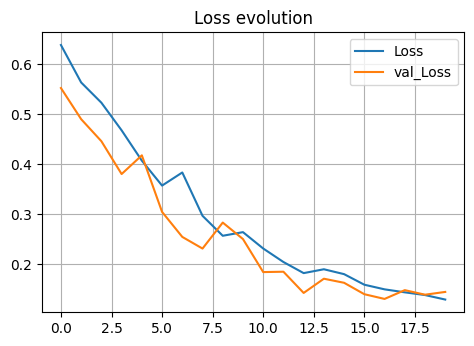

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_73.history['loss'], label='Loss')
plt.plot(history_73.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

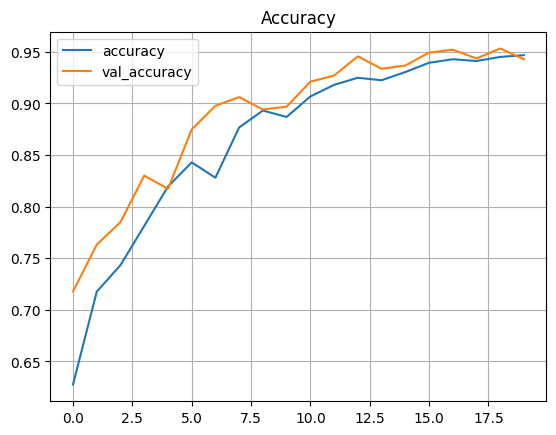

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_73.history['accuracy'],label='accuracy')
plt.plot(history_73.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_73, test_acc_73 = model_73.evaluate(test_generator_73)
print('Test loss:', test_loss_73)
print('Test accuracy:', test_acc_73)

78/78 [==============================] - 7s 94ms/step - loss: 0.1445 - accuracy: 0.9428
Test loss: 0.14447982609272003
Test accuracy: 0.9428341388702393


In [ ]:
predict_73 = model_73.predict(test_generator_73)

78/78 [==============================] - 7s 92ms/step


In [ ]:
prediction_73 = predict_73.argmax(axis=-1)
test_df_73['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction_73]
test_df_73

,image_id,Gender,Prediction
9217,186758.jpg,1,0
7388,149922.jpg,1,0
5916,120437.jpg,0,0
3110,063127.jpg,1,0
5983,121620.jpg,0,0
...,...,...,...
6890,140076.jpg,0,0
3881,079123.jpg,0,0
9147,185681.jpg,0,0
4929,100072.jpg,0,0


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_73['Gender'], test_df_73["Prediction"], labels= labels)
cm

array([[   0, 1241],
       [   0, 1243]])

In [ ]:
true_classes = test_generator_73.classes

class_labels = list(test_generator_73.class_indices.keys())

report_73 = classification_report(true_classes, prediction_73, target_names=class_labels)
print(report_73)

              precision    recall  f1-score   support

           0       0.48      1.00      0.65      1184
           1       0.00      0.00      0.00      1300

    accuracy                           0.48      2484
   macro avg       0.24      0.50      0.32      2484
weighted avg       0.23      0.48      0.31      2484



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


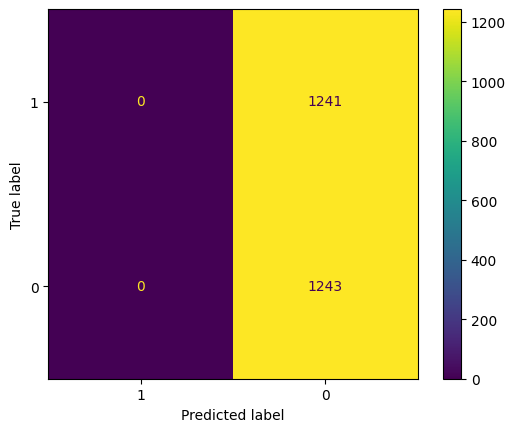

In [ ]:
disp_73 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_73.plot()
plt.show()

## Split Data 60:40

In [ ]:
# create model
model_64 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_64.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_64.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_64 = model_64.fit(train_generator_64, epochs=20, verbose = 1, validation_data=test_generator_64, callbacks=[checkpoint, earlystop])

Epoch 1/20
156/156 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.5215
Epoch 1: val_accuracy improved from -inf to 0.63376, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_64.h5
156/156 [==============================] - 1394s 9s/step - loss: 0.6966 - accuracy: 0.5215 - val_loss: 0.6322 - val_accuracy: 0.6338
Epoch 2/20
156/156 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.6851
Epoch 2: val_accuracy improved from 0.63376 to 0.72313, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_64.h5
156/156 [==============================] - 1128s 7s/step - loss: 0.6081 - accuracy: 0.6851 - val_loss: 0.5726 - val_accuracy: 0.7231
Epoch 3/20
156/156 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.7392
Epoch 3: val_accuracy improved from 0.72313 to 0.78382, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_64

#### Plotting Result Model

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_64.history['loss'], label='Loss')
plt.plot(history_64.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_64.history['accuracy'],label='accuracy')
plt.plot(history_64.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_64, test_acc_64 = model_64.evaluate(test_generator_64)
print('Test loss:', test_loss_64)
print('Test accuracy:', test_acc_64)

In [ ]:
predict_64 = model_64.predict(test_generator_64)

In [ ]:
prediction_64 = predict_64.argmax(axis=-1)
test_df_64['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction_64]
test_df_64

In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_64['Gender'], test_df_64["Prediction"], labels= labels)
cm

In [ ]:
true_classes = test_generator_64.classes

class_labels = list(test_generator_64.class_indices.keys())

report_64 = classification_report(true_classes, prediction_64, target_names=class_labels)
print(report_64)

In [ ]:
disp_64 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_64.plot()
plt.show()